In [4]:
!pip install peft
!pip install datasets


CUDA 사용 가능: False
현재 장치: cpu
총 973개 데이터 처리 시작



Processing: 100%|██████████| 1/1 [02:11<00:00, 131.21s/it]


배치 1/1 처리 완료

전체 처리 완료

별점 분포:
sentiment_score_discrete
1     16
2     12
3     57
4    538
5    350
Name: count, dtype: int64



c:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


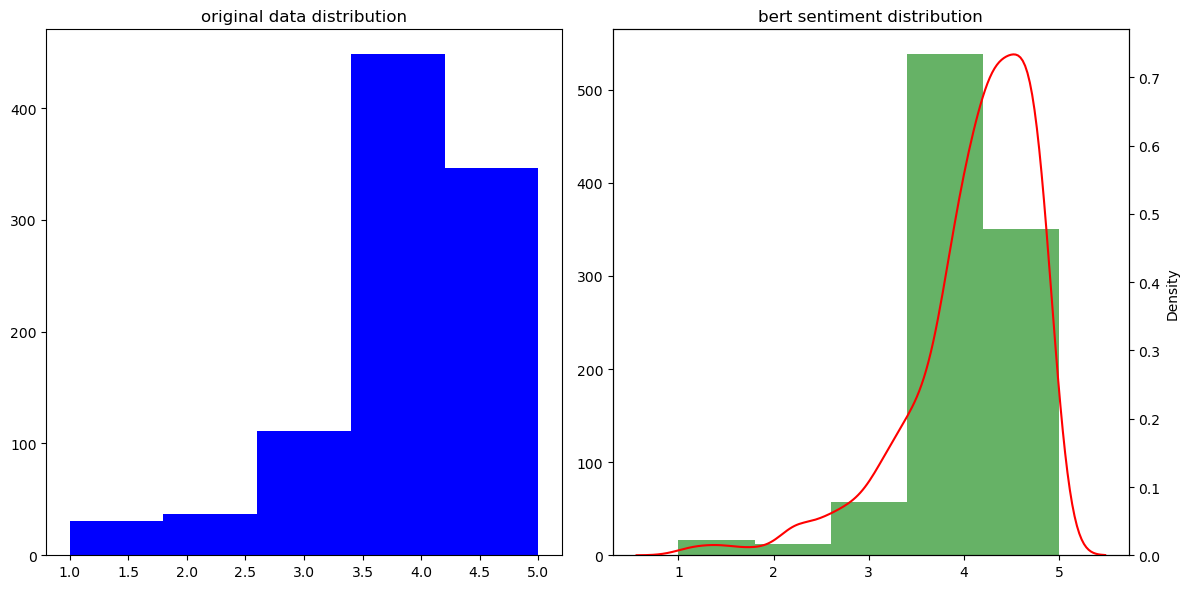

In [3]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm import tqdm
import os
from collections import Counter
from peft import PeftModel, PeftConfig
import seaborn as sns
import matplotlib.pyplot as plt


class SentimentAnalyzer:
    def __init__(self, base_model_path="nlptown/bert-base-multilingual-uncased-sentiment", 
                 lora_model_path=None):
        # GPU 사용 여부 확인
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Load base model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(base_model_path)
        base_model = AutoModelForSequenceClassification.from_pretrained(base_model_path)
        
        if lora_model_path:
            # Load and merge LoRA weights
            config = PeftConfig.from_pretrained(lora_model_path)
            peft_model = PeftModel.from_pretrained(base_model, lora_model_path)
            # Merge LoRA weights with base model
            merged_model = peft_model.merge_and_unload()
            
            self.classifier = pipeline(
                "sentiment-analysis",
                model=merged_model,
                tokenizer=self.tokenizer,
                top_k=None,
                device=device
            )
        else:
            self.classifier = pipeline(
                "sentiment-analysis",
                model=base_model,
                tokenizer=self.tokenizer,
                top_k=None,
                device=device
            )

    def get_sentiments(self, text):
        """연속형과 이산형 점수 모두 반환"""
        scores = self.classifier(text)[0]

        # 연속형 점수 계산 (가중 평균)
        weighted_score = sum(float(score['label'][0]) * score['score'] for score in scores)
        continuous_score = round(weighted_score, 3)

        # 이산형 점수 계산 (가장 높은 확률의 별점)
        discrete_label = max(scores, key=lambda x: x['score'])['label']
        discrete_score = int(discrete_label[0])
        discrete_confidence = round(max(scores, key=lambda x: x['score'])['score'], 3)

        return continuous_score, discrete_score, discrete_confidence

    def analyze_long_text(self, text, max_tokens=450):
        # 원본 텍스트의 토큰 수 확인
        original_tokens = self.tokenizer.encode(text)
        was_split = len(original_tokens) > max_tokens

        if not was_split:
            # 토큰 수가 max_tokens 이하면 그대로 처리
            continuous_score, discrete_score, discrete_conf = self.get_sentiments(text)
            return continuous_score, discrete_score, discrete_conf, was_split

        # 토큰을 청크로 나누기
        chunks = []
        for i in range(0, len(original_tokens), max_tokens):
            chunk_tokens = original_tokens[i:i+max_tokens]
            chunk_text = self.tokenizer.decode(chunk_tokens)
            chunks.append(chunk_text)

        # 각 청크 분석
        continuous_scores = []
        discrete_scores = []
        confidence_scores = []

        for chunk in chunks:
            try:
                cont_score, disc_score, conf = self.get_sentiments(chunk)
                continuous_scores.append(cont_score)
                discrete_scores.append(disc_score)
                confidence_scores.append(conf)
            except Exception as e:
                print(f"Error processing chunk: {str(e)}")
                continue

        if not continuous_scores:  # 모든 청크가 실패한 경우
            raise Exception("Failed to process all chunks")

        # 평균 계산
        avg_continuous = round(sum(continuous_scores) / len(continuous_scores), 3)
        # 가장 빈번한 별점
        most_common_rating = Counter(discrete_scores).most_common(1)[0][0]
        # 평균 confidence
        avg_confidence = round(sum(confidence_scores) / len(confidence_scores), 3)

        return avg_continuous, most_common_rating, avg_confidence, was_split

    def read_file(self, file_path):
        file_extension = os.path.splitext(file_path)[1].lower()

        if file_extension == '.csv':
            encodings = ['utf-8', 'cp949', 'euc-kr', 'latin1']
            for encoding in encodings:
                try:
                    return pd.read_csv(file_path, encoding=encoding)
                except UnicodeDecodeError:
                    continue
                except Exception as e:
                    print(f"Error with {encoding} encoding: {str(e)}")
                    continue
            raise ValueError(f"Could not read file with any of the encodings: {encodings}")
        elif file_extension in ['.xlsx', '.xls']:
            return pd.read_excel(file_path)
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")

    def save_file(self, df, file_path = None):
        file_extension = os.path.splitext(file_path)[1].lower()

        if file_extension == '.csv':
            df.to_csv(file_path, index=False)
        elif file_extension in ['.xlsx', '.xls']:
            df.to_excel(file_path, index=False)

    def process_file(self, file_path, text_column, save_path=None, batch_size=1000):
        df = self.read_file(file_path)
        if df["Rating"].value_counts().shape[0] > 5:
            def convert_to_categories(rating):
                if rating in [1, 2]:
                    return 1
                elif rating in [3, 4]:
                    return 2
                elif rating in [5, 6]:
                    return 3
                elif rating in [7, 8]:
                    return 4
                else:
                    return 5

            # 등급 변환 적용
            df['Rating'] = df['Rating'].apply(convert_to_categories)
        total_rows = len(df)
        num_batches = (total_rows + batch_size - 1) // batch_size

        # 결과 컬럼만 생성
        df['sentiment_score_continuous'] = None
        df['sentiment_score_discrete'] = None

        print(f"\nCUDA 사용 가능: {torch.cuda.is_available()}")
        print(f"현재 장치: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
        print(f"총 {total_rows}개 데이터 처리 시작\n")

        for i in tqdm(range(0, total_rows, batch_size), desc="Processing"):
            batch_end = min(i + batch_size, total_rows)

            for idx in range(i, batch_end):
                try:
                    text = str(df.loc[idx, text_column])
                    if pd.isna(text) or text.strip() == '':
                        df.loc[idx, 'sentiment_score_continuous'] = None
                        df.loc[idx, 'sentiment_score_discrete'] = None
                    else:
                        cont_score, disc_score, _, _ = self.analyze_long_text(text)
                        df.loc[idx, 'sentiment_score_continuous'] = cont_score
                        df.loc[idx, 'sentiment_score_discrete'] = disc_score

                except Exception as e:
                    print(f"\nError processing row {idx}: {str(e)}")
                    df.loc[idx, 'sentiment_score_continuous'] = None
                    df.loc[idx, 'sentiment_score_discrete'] = None

            save_path = save_path or file_path
            self.save_file(df, save_path)
            print(f"\n배치 {i // batch_size + 1}/{num_batches} 처리 완료")

        print("\n전체 처리 완료")
        print("\n별점 분포:")
        print(df['sentiment_score_discrete'].value_counts().sort_index())
        

        return df
    def EDA_data(self, data):
        plt.figure(figsize=(12,6))
        
        plt.subplot(1,2,1)
        plt.title("original data distribution")
        plt.hist(data["Rating"],color = "blue", bins = 5)
        
        ax1 = plt.subplot(1,2,2)
        plt.title("bert sentiment distribution")
        ax1.hist(data["sentiment_score_discrete"],color = 'green', alpha = 0.6, bins = 5)
        ax2 = ax1.twinx()
        sns.kdeplot(data = data["sentiment_score_continuous"], color = 'red', ax = ax2)
        
        plt.tight_layout()
        plt.show()
        
        


if __name__ == "__main__":
    # LoRA 모델을 사용하는 경우
    analyzer = SentimentAnalyzer(
    base_model_path="nlptown/bert-base-multilingual-uncased-sentiment",
    lora_model_path=r"C:\Users\Administrator\Desktop\PADA_LAB\sentimnet\model\hotel_full_data_model"  # LoRA 모델 경로를 None으로 설정
)

    df = analyzer.process_file(
        file_path=r'C:\Users\Administrator\Desktop\PADA_LAB\calculated\sampled_hotel_1000_calculated_ctm.csv',
        text_column='Review_Text',
        # save_path=r'C:\Users\Administrator\Desktop\PADA_LAB\calculated\sampled_hotel_BERT_test.csv',
        batch_size=1500
    )
    analyzer.EDA_data(df)

    # 리소스 해제
    del analyzer.classifier
    del analyzer

In [17]:
columns = ['Rating','Review_Text','sentiment_score_continuous', 'sentiment_score_discrete']
df_select = df[columns].copy()
df_select["deviation"] = df_select["Rating"] - df_select["sentiment_score_continuous"]
df_select['abs_deviation'] = abs(df_select['deviation'])
df_select = df_select.sort_values('abs_deviation', ascending=False)
df_select.head(20)
df_select.to_csv(r'C:\Users\Administrator\Desktop\PADA_LAB\sentimnet\Rating_sample.csv ', index=False)

### 원본 별점 분포

별점 분포:
sentiment_score_discrete
1     31
2     37
3    111
4    448
5    346
Name: count, dtype: int64

### 기본 모델 별점 분포

별점 분포:
sentiment_score_discrete
1     41
2    105
3    172
4    401
5    254
Name: count, dtype: int64

### LoRA 파인튜닝 모델

별점 분포:
sentiment_score_discrete
1     64
2      2
3     19
4    637
5    251
Name: count, dtype: int64
